## Importing the data :

### Intialization Spark session:

In [1]:
import pyspark
import pyspark.sql
from pyspark.sql import *
import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.sql.functions import col, udf, explode, rank, unix_timestamp, from_unixtime
from pyspark.ml.feature import Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window
import numpy as np

conf = pyspark.SparkConf().setMaster("local[*]").setAll([
                                   ('spark.executor.memory', '12g'),  # find
                                   ('spark.driver.memory','4g'), # your
                                   ('spark.driver.maxResultSize', '2G'), # setup
                                   ('spark.sql.broadcastTimeout',  '1000')
                                  ])
# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

# FIX for Spark 2.x
locale = sc._jvm.java.util.Locale
locale.setDefault(locale.forLanguageTag("en-US"))




### Importing data:

The info function outputs the dimenstions of the dataframe and the name of columns:

In [2]:
### Defining the info function :
def info(df,show=True,n=2):
    print("Number of columns: ",len(df.columns))
    print("Number of rows: ", df.count())
    print("Name of columns and types:", df.dtypes)
    if show:
        df.show(n)

In [3]:
## Player_summaries:
Player_summaries=spark.read.csv("data/Player_summaries.csv",header=True).select("steamid","lastlogoff","primaryclanid",
                                                                               "timecreated","gameid","gameserverip",
                                                                                "loccountrycode","locstatecode",
                                                                                "loccityid","dateretrieved")
info(Player_summaries,False)


Number of columns:  10
Number of rows:  250000
Name of columns and types: [('steamid', 'string'), ('lastlogoff', 'string'), ('primaryclanid', 'string'), ('timecreated', 'string'), ('gameid', 'string'), ('gameserverip', 'string'), ('loccountrycode', 'string'), ('locstatecode', 'string'), ('loccityid', 'string'), ('dateretrieved', 'string')]


In [4]:
## Game_publisher:
Game_publisher = spark.read.csv("data/Games_publishers.csv", header=True)
info(Game_publisher)

Number of columns:  2
Number of rows:  18761
Name of columns and types: [('appid', 'string'), ('Publisher', 'string')]
+------+---------+
| appid|Publisher|
+------+---------+
|207990|     null|
|215220|     null|
+------+---------+
only showing top 2 rows



In [5]:
## Game_genre:
Game_genre = spark.read.csv("data/Games_Genres.csv", header=True)
info(Game_genre,True,4)

Number of columns:  2
Number of rows:  39669
Name of columns and types: [('appid', 'string'), ('Genre', 'string')]
+-----+-----+
|appid|Genre|
+-----+-----+
| 7290|  RPG|
| 8980|  RPG|
|18010|  RPG|
|18040|  RPG|
+-----+-----+
only showing top 4 rows



In [6]:
## Game_developers:
Game_developer = spark.read.csv("data/Games_developers.csv", header=True)
info(Game_developer,True,4)

Number of columns:  2
Number of rows:  19333
Name of columns and types: [('appid', 'string'), ('Developer', 'string')]
+------+---------+
| appid|Developer|
+------+---------+
|462530|       8i|
|452420|       M2|
|466530|       M2|
|366960|       UD|
+------+---------+
only showing top 4 rows



In [7]:
### Game_1:
Game_1 = spark.read.csv("data/Games_1.csv", header=True)
info(Game_1,True,4)

Number of columns:  5
Number of rows:  628117
Name of columns and types: [('steamid', 'string'), ('appid', 'string'), ('playtime_2weeks', 'string'), ('playtime_forever', 'string'), ('dateretrieved', 'string')]
+-----------------+------+---------------+----------------+--------------------+
|          steamid| appid|playtime_2weeks|playtime_forever|       dateretrieved|
+-----------------+------+---------------+----------------+--------------------+
|76561198001291264|  8870|           null|            1392|2013-06-09 01:01:...|
|76561198001291264|   400|           null|             239|2013-06-09 01:01:...|
|76561198001291264|212910|           null|             130|2013-06-09 01:01:...|
|76561198001291264|   550|           null|           17547|2013-06-09 01:01:...|
+-----------------+------+---------------+----------------+--------------------+
only showing top 4 rows



In [8]:
### ALL_games:
all_games=spark.read.csv("data/App_ID_Info.csv", header=True)
info(all_games,False)

Number of columns:  8
Number of rows:  17783
Name of columns and types: [('appid', 'string'), ('Title', 'string'), ('Type', 'string'), ('Price', 'string'), ('Release_Date', 'string'), ('Rating', 'string'), ('Required_Age', 'string'), ('Is_Multiplayer', 'string')]


### Joining Dataframes:

We can see that the four dataframes: Game_1, Game_publisher, Game_genre and Game_developer, share the column "appid". We can join all the four dataframes based on the index. 
Since our main concern is games we will apply a left join, by keeping the appid index of the dataframe Game_1, and matching all information contained in the remaining datasets: 

But before, we will add all information concerning one single game to the dataset all_games so that we have one data set gathering all information about games.

In [9]:
### Joining the datasets to get a complete information data set about games:
Game=all_games.join(Game_genre, on=['appid'], how='left').join(Game_publisher, on=['appid'], how='left').join(Game_developer,on=['appid'], how='left')
info(Game,False)

Number of columns:  11
Number of rows:  46803
Name of columns and types: [('appid', 'string'), ('Title', 'string'), ('Type', 'string'), ('Price', 'string'), ('Release_Date', 'string'), ('Rating', 'string'), ('Required_Age', 'string'), ('Is_Multiplayer', 'string'), ('Genre', 'string'), ('Publisher', 'string'), ('Developer', 'string')]


Remark: Some games have multiple genre, publisher and Developer. It is one vs many join:

In [10]:
# joining Game_1 with a subset of columns of Game:
Partial_game= Game.select("appid","Genre","Publisher","Developer")
Joined_game=Game_1.join(Partial_game,on="appid",how="left")
info(Joined_game)

Number of columns:  8
Number of rows:  1163206
Name of columns and types: [('appid', 'string'), ('steamid', 'string'), ('playtime_2weeks', 'string'), ('playtime_forever', 'string'), ('dateretrieved', 'string'), ('Genre', 'string'), ('Publisher', 'string'), ('Developer', 'string')]
+------+-----------------+---------------+----------------+--------------------+------+---------------+--------------+
| appid|          steamid|playtime_2weeks|playtime_forever|       dateretrieved| Genre|      Publisher|     Developer|
+------+-----------------+---------------+----------------+--------------------+------+---------------+--------------+
|108800|76561198077274880|           null|              47|2013-09-23 05:39:...|Action|Electronic Arts|Crytek Studios|
|108800|76561198028125440|           null|             427|2013-07-12 17:16:...|Action|Electronic Arts|Crytek Studios|
+------+-----------------+---------------+----------------+--------------------+------+---------------+--------------+
only

### the number of games per publisher:

In [11]:
import matplotlib.pyplot as plt

After a groupBy, The Dataframe is small enough to be moved to Pandas:

In [12]:
## Rmoving null publishers:
Filtered_game_publisher=Game.where(Game.Publisher.isNotNull())
## Grouping and aggregating:
game_per_publisher= Filtered_game_publisher.groupBy('Publisher').agg(countDistinct("appid")\
                                                           .alias("number of games"))\
                                                           .sort(desc("number of games"))\
                                                           .toPandas()
## Top 10 publishers:                                           
Top_ten_publishers=game_per_publisher.iloc[0:10,]

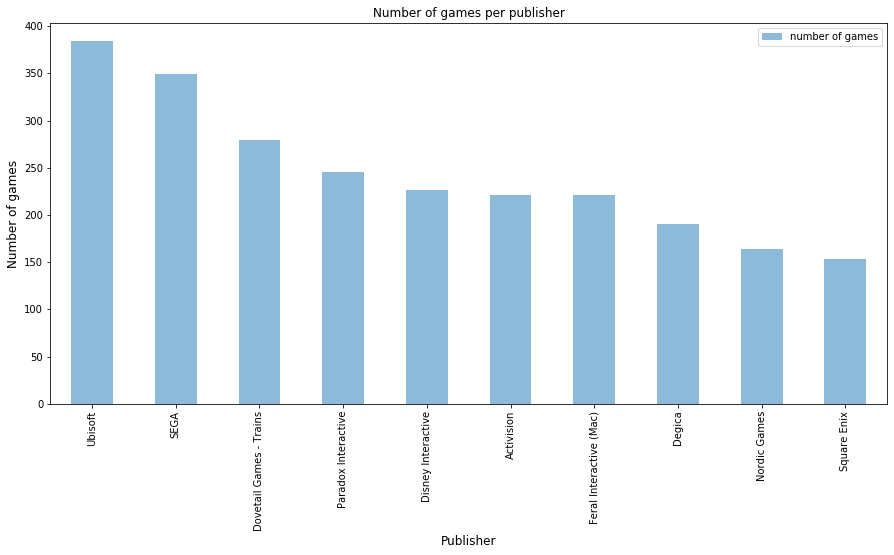

In [13]:
## Barplot fo the top10 publishers:
Top_ten_publishers.plot(kind='bar', x='Publisher', y='number of games', alpha=0.5, capsize=5, 
               figsize=(15,7))

plt.xlabel("Publisher", size='large')
plt.ylabel("Number of games", size="large")
plt.title("Number of games per publisher", size="large")
plt.show();


### The number of games per genre:

In [14]:
### Removing the missing vulues:
Filtered_game_genre=Game.where(Game.Genre.isNotNull())
## Grouping and aggregating:
game_per_genre= Filtered_game_genre.groupBy('Genre').agg(countDistinct("appid")\
                                                           .alias("number of games"))\
                                                           .sort(desc("number of games"))\
                                                           .toPandas()
## Top 10 publishers:                             
Top_ten_genre=game_per_genre.iloc[0:10,]


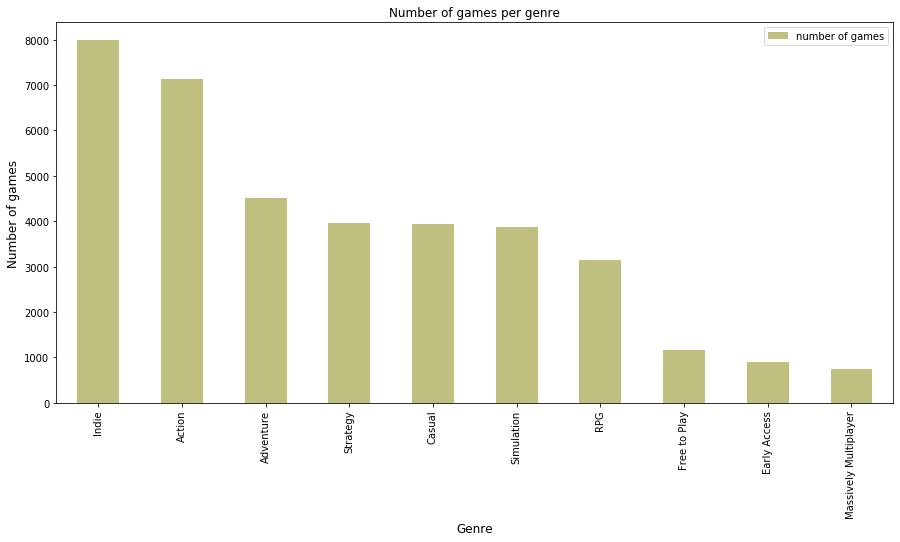

In [15]:
## Barplot fo the top10 publishers:
Top_ten_genre.plot(kind='bar', x='Genre', y='number of games', alpha=0.5, capsize=5, 
               figsize=(15,7), color="olive")

plt.xlabel("Genre", size='large')
plt.ylabel("Number of games", size="large")
plt.title("Number of games per genre", size="large")
plt.show();

### Day/Hour of account creation:
As we saw above, the type of time created is a string, so we have to converted to a datetime type then we extract the year, the month, the day and the hour of creation of each account.  

In [16]:
### the date is given in the following form: YYYY-MM-DD HH:mm:s
Player_summaries.select("timecreated").distinct().show(5)

+-------------------+
|        timecreated|
+-------------------+
|2012-12-25 10:16:58|
|2012-12-24 08:22:32|
|2007-03-20 13:41:46|
|2012-11-22 18:15:10|
|2012-11-29 08:13:37|
+-------------------+
only showing top 5 rows



In [17]:
## Number of missing dates:
Player_summaries.filter(Player_summaries.timecreated.isNull()).count()

14810

In [18]:
## selecting necessary columns:
date_time = Player_summaries.select("steamid","timecreated")
##Removing missing dates:
filtered_date_time = date_time.where(date_time.timecreated.isNotNull())
info(filtered_date_time)

Number of columns:  2
Number of rows:  235190
Name of columns and types: [('steamid', 'string'), ('timecreated', 'string')]
+-----------------+-------------------+
|          steamid|        timecreated|
+-----------------+-------------------+
|76561197972581736|2004-12-29 09:00:06|
|76561198080962334|2013-01-08 13:54:23|
+-----------------+-------------------+
only showing top 2 rows



In [19]:
from pyspark.sql.types import DateType, TimestampType
from datetime import datetime

## Here we will parse the dates into a TimestampType
to_date = udf(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S'), TimestampType())

updated_date = filtered_date_time.withColumn('datecreated',to_date(col('timecreated')))

## We extract the year/the month/the day of the month/ the hour from the datecreated column 
updated_date = updated_date.select('steamid','datecreated',year(col('datecreated')).alias('year')\
                                 ,month(col('datecreated')).alias('month')\
                                ,dayofmonth(col('datecreated')).alias('day_month')\
                                ,hour(col('datecreated')).alias('hour'))
info(updated_date,True,10)

Number of columns:  6
Number of rows:  235190
Name of columns and types: [('steamid', 'string'), ('datecreated', 'timestamp'), ('year', 'int'), ('month', 'int'), ('day_month', 'int'), ('hour', 'int')]
+-----------------+-------------------+----+-----+---------+----+
|          steamid|        datecreated|year|month|day_month|hour|
+-----------------+-------------------+----+-----+---------+----+
|76561197972581736|2004-12-29 09:00:06|2004|   12|       29|   9|
|76561198080962334|2013-01-08 13:54:23|2013|    1|        8|  13|
|76561198074103256|2012-10-23 01:16:14|2012|   10|       23|   1|
|76561198001266978|2008-09-16 00:39:53|2008|    9|       16|   0|
|76561198028014428|2010-07-22 02:13:58|2010|    7|       22|   2|
|76561198000701276|2008-08-21 09:08:49|2008|    8|       21|   9|
|76561198028706706|2010-08-08 11:48:35|2010|    8|        8|  11|
|76561198081192810|2013-01-11 14:05:44|2013|    1|       11|  14|
|76561197972561528|2004-12-28 20:35:55|2004|   12|       28|  20|
|765611

Now we can group the steamid subject to the date of account creation:

In [20]:
### Grouping the accounts subject to the date of creation
grouped_date = updated_date.groupBy(['year','month','day_month','hour']).agg(countDistinct("steamid")\
                                                                      .alias("Number of accounts created"))\
                                                                      .sort(desc("Number of accounts created")).toPandas()
grouped_date.head(10)                                                                      

,year,month,day_month,hour,Number of accounts created
0,2012,12,25,10,292
1,2012,12,25,8,279
2,2012,12,25,11,230
3,2012,11,28,11,219
4,2012,11,28,10,216
5,2012,11,28,9,215
6,2012,12,25,7,208
7,2012,12,25,4,208
8,2012,11,28,8,205
9,2012,12,24,11,204


We can see that 2012/12/25 at 10am is the day with maximum account creation. This make sense, since it was a christmas day and a lot of well known games were released between november and december 2012 on the steam plateform ( the walking dead, Far Cry 3, call of duty black ops ...).

### Best Month to release a game on steam:

In [21]:
## grouping subject to month and aggregating statistics for the confidence intervals
month_release = grouped_date.groupby('month').agg({'Number of accounts created':['mean','std','count']})
month_release.columns = ['mean','std','count']
month_release = month_release.reindex(columns=(month_release.columns))

## Renaming the index to months names for the plots
month_release = month_release.rename(index={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})

##P Transforming the index to a column for the plotting
month_release = month_release.reset_index()
month_release

,month,mean,std,count
0,Jan,23.787091,30.940605,1038
1,Feb,11.264970,9.099986,668
2,Mar,30.993321,27.815447,1048
3,Apr,19.468085,15.612099,376
4,May,2.442922,1.452673,219
5,Jun,47.175904,17.348110,415
6,Jul,36.522500,13.211391,400
7,Aug,31.283784,18.151977,1036
8,Sep,17.970126,9.022145,636
9,Oct,51.073684,24.815198,380




We will make the assumption that the number of accounts created in a month follows a normal distribution. 
the assumption is based on : the number of account created follows a light tailed distribution ( If we add an extremal observation it will not affect too much the mean. )  

we will built 99% confidence intervals based on the theoretical quantile of a standard normal distribution $q$=2.576

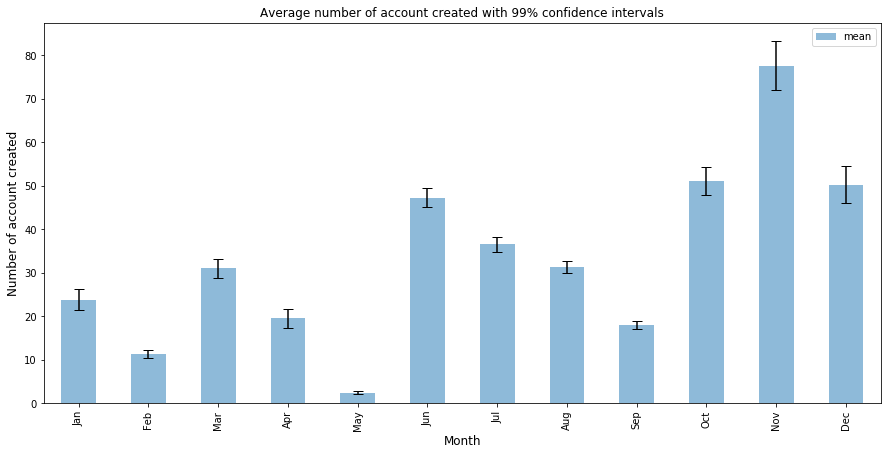

In [22]:
Z = 2.576 #The probability of a randomized gaussian variable to be under 2.576 is 0.995

month_release['Error'] = Z * month_release["std"] / np.sqrt(month_release["count"])

month_release.plot(kind='bar', x='month', y='mean', yerr = 'Error', alpha=0.5, capsize=5, 
               figsize=(15,7))

plt.xlabel("Month", size='large')
plt.ylabel("Number of account created", size="large")
plt.title("Average number of account created with 99% confidence intervals", size="large")
plt.show();


We can see that, by far, November is the best month to release a game on steam.